In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL.Image
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from statistics import mean
import random

import seaborn
from tqdm import tqdm
from shared_interest.datasets.imagenet import ImageNet
from shared_interest.shared_interest import shared_interest
from shared_interest.util import flatten, normalize_0to1, binarize_std, binarize_percentile
from interpretability_methods.gradcam import GradCAM
from interpretability_methods.util import visualize_saliency

from matplotlib.legend_handler import HandlerPathCollection

In [3]:
imagenet_dir = '' # TODO: add your imagenet directory here.'
data_dir = '' # TODO: add your model data directory here.

imagenet_dir = '/nobackup/users/hbang/data/imagenet/val_old/'
image_dir = os.path.join(imagenet_dir, 'images')
annotation_dir = os.path.join(imagenet_dir, 'annotations')

In [6]:
# ImageNet transforms
image_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                           std=[0.229, 0.224, 0.225]),
                                     ])

ground_truth_transform = transforms.Compose([transforms.ToPILImage(),
                                             transforms.Resize(256, PIL.Image.NEAREST),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor()])

reverse_image_transform = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], 
                                                                   std=[4.3668, 4.4643, 4.4444]),
                                              transforms.Normalize(mean=[-0.485, -0.456, -0.406], 
                                                                   std=[1, 1, 1]),
                                              transforms.ToPILImage(),])

In [7]:
dataset = ImageNet(image_dir, annotation_dir, image_transform, ground_truth_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, 
                                         num_workers=10, pin_memory=True)

In [8]:
# list of models you want to run 

model_names = ['convnext_tiny', 'convnext_small', 'convnext_base', 'convnext_large',
               'efficientnet_v2_s', 'regnet_y_128gf', 'regnet_y_16gf',
               'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_8gf', 'regnet_x_16gf', 
               'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_8gf', 'resnext50_32x4d', 'resnext101_32x8d', 
               'resnet101', 'resnet152', 'resnet50', 'wide_resnet50_2', 'wide_resnet101_2']

In [9]:
# indicies of ImageNet images with ground truth annotations outside the cropped region
# (batch size of 16)

nan_gtc_index = {341: [7], 469: [5], 959: [1], 1009: [7], 1012: [2], 1255: [10], 1266: [9], 1267: [1, 4], 1268: [7, 9], 1270: [3], 1289: [13], 1300: [0, 3, 4, 6, 8, 9, 14], 1301: [4, 5, 9], 1302: [3, 7, 10, 13], 1303: [11], 1305: [14], 1311: [10], 1335: [0], 1336: [3], 1340: [11], 1341: [13], 1342: [1, 9, 10], 1343: [6, 13], 1344: [0, 6, 14], 1345: [0, 1, 2, 15], 1346: [6, 12, 13], 1351: [2], 1354: [9], 1355: [14], 1366: [4, 10], 1367: [3], 1372: [13], 1422: [2], 1431: [1], 1447: [4], 1452: [10], 1530: [7], 1560: [11], 1593: [4], 1607: [8], 1608: [1], 1609: [9], 1631: [9], 1632: [2, 6], 1633: [8], 1659: [6, 15], 1675: [12], 1676: [2, 13], 1740: [12], 1743: [3], 1745: [9], 1780: [8], 1817: [3], 1828: [2], 1829: [10], 1881: [11, 15], 1883: [5, 7, 10, 13], 1884: [1, 4], 1911: [11], 1922: [13], 1973: [11], 2007: [2], 2008: [10], 2034: [13], 2047: [13], 2084: [8], 2085: [4], 2117: [4], 2125: [10], 2133: [3], 2168: [7], 2186: [11], 2195: [5], 2215: [1], 2234: [14], 2235: [2, 3, 4, 12, 13], 2236: [0, 1, 5, 6, 9, 10, 11, 13], 2237: [1, 2, 4, 5], 2257: [7], 2286: [8], 2293: [10], 2318: [15], 2323: [12], 2325: [13], 2332: [2, 4, 6, 11], 2333: [7, 8, 12, 14], 2334: [3, 4, 5], 2362: [12], 2397: [5], 2402: [0, 9], 2423: [9], 2453: [15], 2480: [0], 2481: [1], 2517: [8], 2558: [11, 13], 2559: [0], 2601: [1], 2627: [11], 2634: [5], 2643: [8], 2663: [9, 12, 14], 2664: [2, 7], 2694: [3], 2781: [8], 2782: [2, 7, 9], 2783: [0, 5, 6, 8, 9, 10, 11], 2784: [1, 4], 2833: [13], 2876: [11], 2877: [15], 2927: [9], 2956: [1], 2961: [8], 2970: [13], 2974: [0], 3086: [13]}

In [10]:
# to get the final convolutional layer for GradCAM
def final_layer(model_name, model):
    if ('convnext' in model_name):
        return model.features[7][2].block[0]
    elif (model_name == 'efficientnet_v2_s'):
        return model.features[7][0]
    elif ('efficientnet' in model_name):
        return model.features[8][0]
    elif ('regnet_y' in model_name):
        if any(size in model_name for size in ['128', '16', '32', '3_2', '8']):
            index = 0
        elif any(size in model_name for size in ['1_6']):
            index = 1
        return model.trunk_output.block4[index].f.c[0]
    elif ('regnet_x' in model_name):
        if any(size in model_name for size in ['16', '32', '8']):
            index = 0
        elif any(size in model_name for size in ['3_2']):
            index = 1
        return model.trunk_output.block4[index].f.c[0]
    elif ('swin' in model_name):
        return model.features[0][0]
    elif ('resnext' in model_name) or ('resnet' in model_name):
        return model.layer4[2].conv3
    else:
        return None

In [11]:
def binarize_threshold(batch, threshold):
    batch_normalized = normalize_0to1(batch)
    binary_mask = (batch_normalized >= threshold).astype('uint8')
    return binary_mask

In [12]:
def run(model, dataloader, saliency_method, nan_gtc_index):
    """
    Runs the model through the data in the dataloader and computes the 
    predictions, saliency, Shared Interest scores, and Pointing Game.
    """
    model.eval()
    accuracy = 0
    salient_pixel_count = 0
    total_shared_interest_scores = {'iou_coverage': np.array([]),
                                    'ground_truth_coverage': np.array([]),
                                    'saliency_coverage': np.array([]),}
    
    total_predictions = np.array([])
    total_saliency_masks = np.array([[[]]])
    
    for i, (images, ground_truth, labels) in enumerate(tqdm(dataloader, position=0, leave=True)):
        with torch.no_grad():
            images = images.to(device)
            ground_truth = ground_truth.numpy()
            labels = labels.numpy()
            if i in nan_gtc_index:
                nans = nan_gtc_index[i]
                for j in sorted(nans, reverse=True):
                    images = torch.cat([images[0:j], images[j+1:]])
                ground_truth = np.delete(ground_truth, nans, 0)
                labels = np.delete(labels, nans, 0)

            # Compute model predictions
            output = model(images)
            predictions = torch.argmax(output, dim=1).detach().cpu().numpy()
            total_predictions = np.concatenate((total_predictions, predictions))

        # Update metrics
        accuracy += accuracy_score(labels, predictions)

        # Compute saliency
        saliency = flatten(saliency_method.get_saliency(images))
        saliency_masks = binarize_threshold(saliency, 0.5)

        if i == 0: 
            total_saliency_masks = saliency_masks
        else:
            total_saliency_masks = np.concatenate((total_saliency_masks, saliency_masks))

        # Compute Shared Interest scores
        for score in total_shared_interest_scores:
            shared_interest_scores = shared_interest(ground_truth, saliency_masks, score=score)
            total_shared_interest_scores[score] = np.concatenate((total_shared_interest_scores[score], shared_interest_scores))
            
        # Compute pointing game 
        for j in range(saliency.shape[0]):
            saliency_batch = saliency[j]
            ground_truth_batch = ground_truth[j]
            pixel = np.unravel_index(saliency_batch.argmax(), saliency_batch.shape)
            point = ground_truth_batch[pixel[0], pixel[1]]

            # check if most salient feature is in ground truth 
            if point > 0:
                salient_pixel_count += 1
                                
    pointing_game = salient_pixel_count / len(dataloader.dataset)
    accuracy /= i + 1
    print('Accuracy: %.2f' %accuracy)
    print('Pointing Game: %.2f' %pointing_game)
    print('IoU Coverage: %.42f' %mean(total_shared_interest_scores['iou_coverage']))
    return accuracy, pointing_game, total_saliency_masks, total_shared_interest_scores, total_predictions

In [32]:
for model_name in model_names:
    print (model_name)
    # data_path = os.path.abspath(data_dir + "/" + model_name + "/") 

    model = torch.hub.load("pytorch/vision:v0.13.0", model_name, weights="DEFAULT")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    accuracy, pointing_game, saliency_masks, shared_interest_scores, predictions = run(model, dataloader, GradCAM(model, final_layer(model_name, model)), nan_gtc_index)  
    
#     if not os.path.exists(data_path):
#         os.mkdir(data_path)

#     with open(os.path.join(data_path, "saliency_masks.pickle"), "wb") as handle:
#         pickle.dump(saliency_masks, handle, protocol=pickle.HIGHEST_PROTOCOL)
#         del saliency_masks

#     with open(os.path.join(data_path, "shared_interest_scores.pickle"), "wb") as handle:
#         pickle.dump(shared_interest_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
#         del shared_interest_scores

#     with open(os.path.join(data_path, "accuracy.pickle"), "wb") as handle:
#         pickle.dump(accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)
#         del accuracy
    
#     with open(os.path.join(data_path, "pointing_game.pickle"), "wb") as handle:
#         pickle.dump(pointing_game, handle, protocol=pickle.HIGHEST_PROTOCOL)
#         del pointing_game
    break

convnext_tiny


Using cache found in /home/hbang/.cache/torch/hub/pytorch_vision_v0.13.0
  0%|                                                                                                                    | 0/3125 [00:00<?, ?it/s]/nobackup/users/hbang/anaconda3/envs/sharedInterest38/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [17:47<00:00,  2.93it/s]


Accuracy: 0.82
Pointing Game: 0.68
IoU Coverage: 0.353191168321995485612774245964828878641129


In [33]:
colors = ['#808080', '#556b2f', '#228b22', '#7f0000',
          '#483d8b', '#008b8b', '#4682b4', '#00008b',
          '#7f007f', '#8fbc8f', '#b03060', '#ff4500',
          '#ffa500', '#deb887', '#00ff00', '#00ff7f',
          '#dc143c', '#00ffff', '#0000ff', '#a020f0',
          '#adff2f', '#da70d6', '#1e90ff', '#fa8072',
          '#ffff54', '#90ee90', '#add8e6', '#ff1493', 
          '#7b68ee', '#ffc0cb']
random.shuffle(colors)

In [36]:
# get average scores for each model
data_dir = ''
iou_coverage_scores = {}
accuracy_scores = {}
pointing_game_scores = {}
for model_name in model_names: 
    model_path = os.path.abspath(data_dir + "/" + model_name + "/")

    with open(os.path.join(model_path, "shared_interest_scores.pickle"), 'rb') as handle:
        shared_interest_scores = pickle.load(handle)
        iou_coverage_scores[model_name] = mean(shared_interest_scores['iou_coverage'])
    with open(os.path.join(model_path, "accuracy.pickle"), 'rb') as handle:
        accuracy = pickle.load(handle)
        accuracy_scores[model_name] = accuracy
    with open(os.path.join(model_path, "pointing_game_score.pickle"), 'rb') as handle:
        pointing_game = pickle.load(handle)
        pointing_game_scores[model_name] = pointing_game

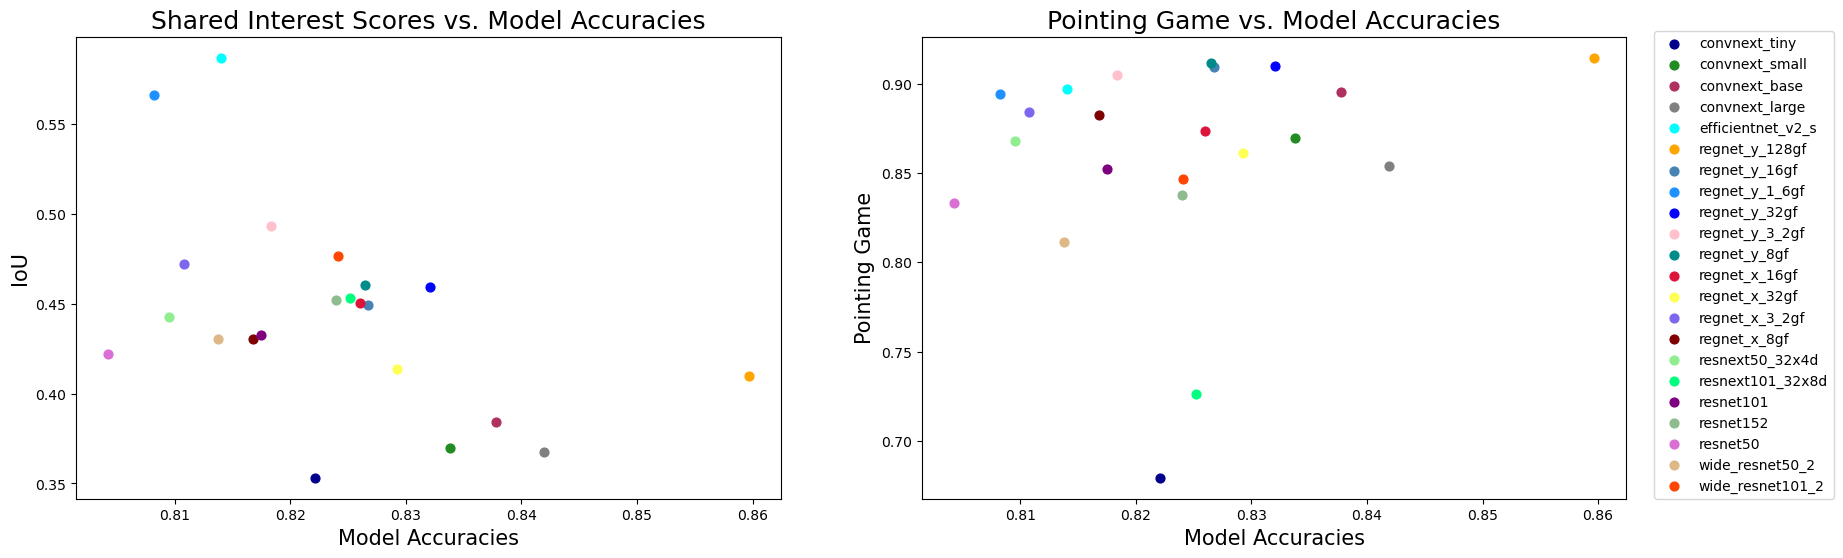

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
i = 0
for model_name in model_names: 
    x = accuracy_scores[model_name]
    y = iou_coverage_scores[model_name]
    sc = ax1.scatter(x, y, s = 40, c = colors[i], label=model_name)
    i += 1
    
ax1.set_title("Shared Interest Scores vs. Model Accuracies", fontdict={'fontsize': 18})
ax1.set_xlabel("Model Accuracies", fontdict={'fontsize': 15})
ax1.set_ylabel("IoU", fontdict={'fontsize': 15})

i = 0
for model_name in pointing_game_scores: 
    x = accuracy_scores[model_name]
    y = pointing_game_scores[model_name]
    sc2 = ax2.scatter(x, y, s = 40, c = colors[i], label=model_name)
    i += 1
    
ax2.set_title("Pointing Game vs. Model Accuracies", fontdict={'fontsize': 18})
ax2.set_xlabel("Model Accuracies", fontdict={'fontsize': 15})
ax2.set_ylabel("Pointing Game", fontdict={'fontsize': 15})

plt.legend(loc=(1.04, 0))

In [15]:
"""Code to visualize the Shared Interest results."""

def ax_off(ax):
    ax.tick_params(
        which='both',
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labeltop=False,
        labelleft=False,
        labelright=False,
    )

[32889, 15969, 4641, 20134, 4495]


Using cache found in /home/hbang/.cache/torch/hub/pytorch_vision_v0.13.0
Using cache found in /home/hbang/.cache/torch/hub/pytorch_vision_v0.13.0
Using cache found in /home/hbang/.cache/torch/hub/pytorch_vision_v0.13.0
Using cache found in /home/hbang/.cache/torch/hub/pytorch_vision_v0.13.0
Using cache found in /home/hbang/.cache/torch/hub/pytorch_vision_v0.13.0
Using cache found in /home/hbang/.cache/torch/hub/pytorch_vision_v0.13.0
Using cache found in /home/hbang/.cache/torch/hub/pytorch_vision_v0.13.0
Using cache found in /home/hbang/.cache/torch/hub/pytorch_vision_v0.13.0
Using cache found in /home/hbang/.cache/torch/hub/pytorch_vision_v0.13.0
Using cache found in /home/hbang/.cache/torch/hub/pytorch_vision_v0.13.0
Using cache found in /home/hbang/.cache/torch/hub/pytorch_vision_v0.13.0
Using cache found in /home/hbang/.cache/torch/hub/pytorch_vision_v0.13.0
Using cache found in /home/hbang/.cache/torch/hub/pytorch_vision_v0.13.0
Using cache found in /home/hbang/.cache/torch/hub/p

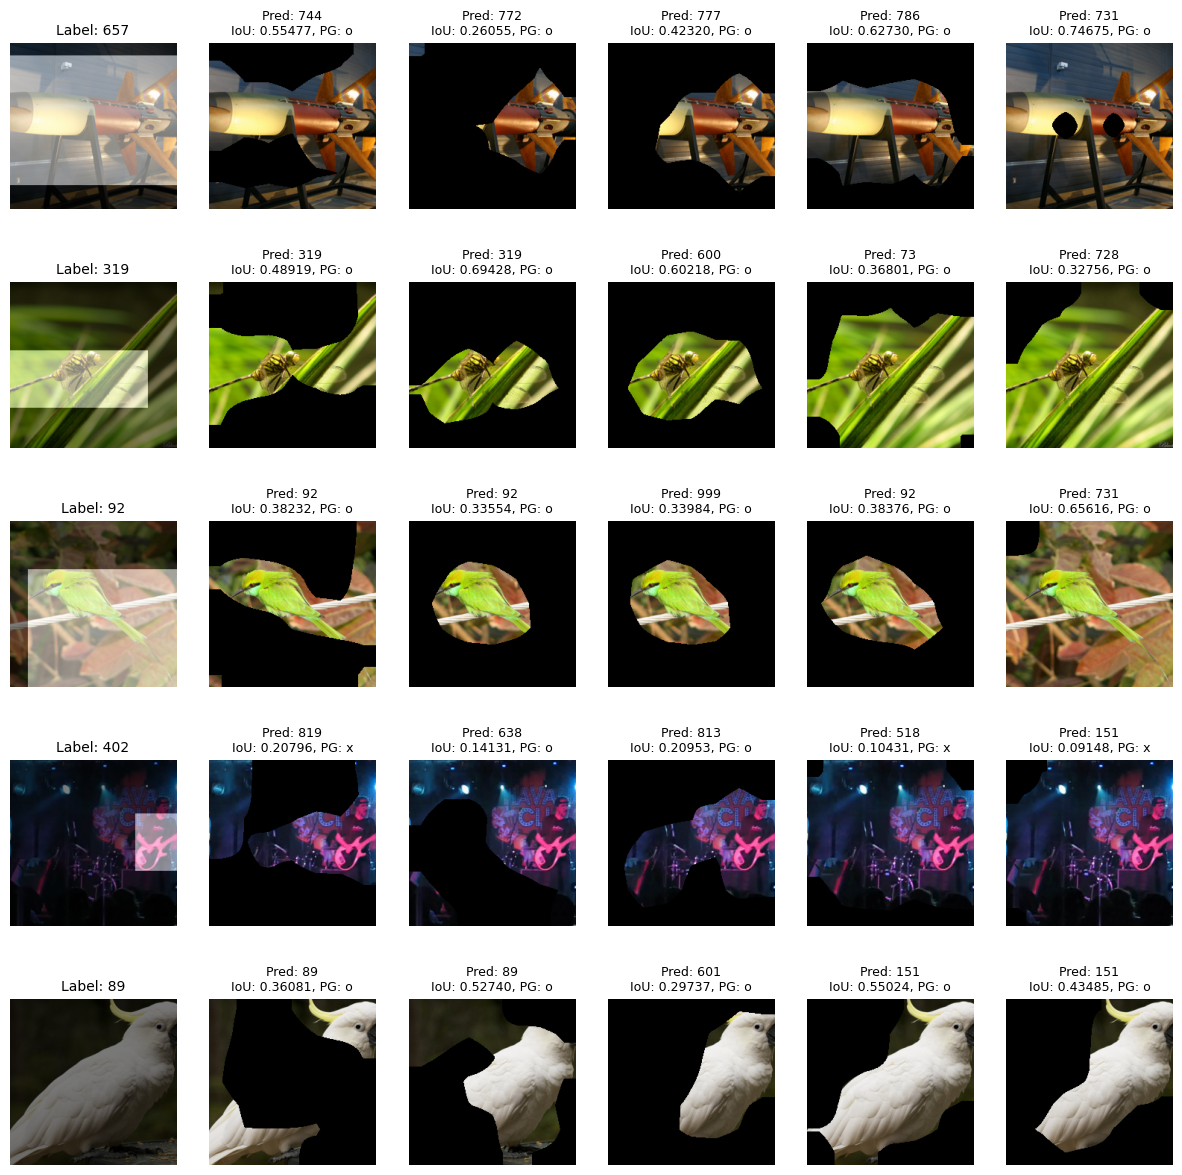

In [17]:
selected_images = random.sample(range(50000), 5)
print (selected_images)

selected_models = ['convnext_tiny', 'resnet101', 'regnet_x_3_2gf', 'regnet_y_1_6gf', 'efficientnet_v2_s']

data = [dataset[i] for i in selected_images]
n = len(selected_images)

fig, ax = plt.subplots(nrows=n, ncols=6, figsize=(15,15))
np.vectorize(ax_off)(ax)

for i, (image, ground_truth, label) in enumerate(data):
    ax[i][0].imshow(reverse_image_transform(image))
    ax[i][0].imshow(ground_truth, alpha =0.5, cmap='gray')
    ax[i][0].set(frame_on=False)
    ax[i][0].set_title('Label: %s' %(label), fontsize=10)

    model_idx = 1
    for model_name in selected_models:
        model = torch.hub.load("pytorch/vision:v0.13.0", model_name, weights="DEFAULT")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        
        output = model(image.unsqueeze(0).to(device))
        predictions = torch.argmax(output, dim=1).detach().cpu().numpy()
        
        saliency_method = GradCAM(model, final_layer(model_name, model))
        saliency = flatten(saliency_method.get_saliency(image.to(device).unsqueeze(0)))
        saliency_masks = binarize_threshold(saliency, 0.5)

        saliency_image = np.array(reverse_image_transform(image)) * np.expand_dims(saliency_masks[0], axis=2)
        
        ax[i][model_idx].imshow(saliency_image)
        ax[i][model_idx].set(frame_on=False)
        iou_coverage = shared_interest(ground_truth.unsqueeze(0).numpy(), saliency_masks, score='iou_coverage')
        pg = 'x'
        for j in range(saliency.shape[0]):
            saliency_batch = saliency[j]
            pixel = np.unravel_index(saliency_batch.argmax(), saliency_batch.shape)
            point = ground_truth[pixel[0], pixel[1]]

            # check if most salient feature is in ground truth 
            if point > 0:
                pg = 'o'
        ax[i][model_idx].set_title('Pred: %s\nIoU: %.5f'%(predictions[0], iou_coverage) + ", PG: " + pg, fontsize = 9)
        model_idx += 1